# 알약 검출 데이터 분석
 
# 이 노트북은 COCO 형식의 알약 데이터를 분석하고 시각화합니다.

## 1. 환경 설정

In [7]:
import sys
sys.path.append('..')

import json
import numpy as np
import pandas as pd
from matplotlib import font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# 프로젝트 모듈
from src.data import COCODataset
from src.utils import Visualizer

# 스타일 설정
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("환경 설정 완료!")


환경 설정 완료!


In [6]:
pwd = Path.cwd()
print(f"현재 작업 디렉토리: {pwd}")

현재 작업 디렉토리: /home/mscho/notebooks/ai3/project/pill-detection-project/notebooks


설정된 폰트: ['NanumGothic']
unicode_minus: False


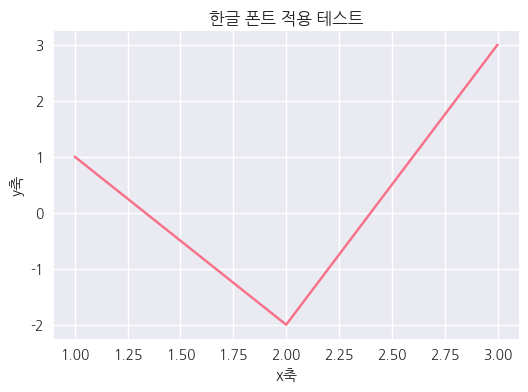

In [8]:
# NanumGothic 폰트 설정
fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumGothic.ttf")
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 수학 텍스트는 기본 설정을 사용하되, 마이너스만 처리
plt.rcParams['mathtext.fontset'] = 'dejavusans'  # 안전한 기본 수학 폰트
plt.rcParams['mathtext.default'] = 'regular'

print(f"설정된 폰트: {plt.rcParams['font.family']}")
print(f"unicode_minus: {plt.rcParams['axes.unicode_minus']}")
plt.figure(figsize=(6, 4))
plt.plot([1, 2, 3], [1, -2, 3])
plt.title("한글 폰트 적용 테스트")
plt.xlabel("x축")
plt.ylabel("y축")
plt.show()

## 2. 데이터 로드

In [15]:
# 데이터 경로 설정
data_root = Path("./ai03-level1-project")
train_img_dir = data_root / "train_images"
train_ann_dir = data_root / "train_annotations"

print(f"이미지 디렉토리: {train_img_dir}")
print(f"어노테이션 디렉토리: {train_ann_dir}")

# 데이터셋 로드
dataset = COCODataset(train_img_dir, train_ann_dir, transform=None)
print(f"\n데이터셋 크기: {len(dataset)} 이미지")

이미지 디렉토리: ai03-level1-project/train_images
어노테이션 디렉토리: ai03-level1-project/train_annotations
데이터셋 준비 완료: 0개 이미지, 0개 클래스

데이터셋 크기: 0 이미지


## 3. 기본 통계

In [10]:
# 통계 수집
stats = {
    'total_images': len(dataset),
    'total_boxes': 0,
    'boxes_per_image': [],
    'class_counts': defaultdict(int),
    'box_sizes': []
}

for i in range(len(dataset)):
    img, target = dataset[i]
    num_boxes = len(target['boxes'])
    
    stats['total_boxes'] += num_boxes
    stats['boxes_per_image'].append(num_boxes)
    
    for label, box in zip(target['labels'], target['boxes']):
        stats['class_counts'][int(label)] += 1
        w = box[2] - box[0]
        h = box[3] - box[1]
        stats['box_sizes'].append((w.item(), h.item()))

print("=== 데이터셋 통계 ===")
print(f"전체 이미지: {stats['total_images']}")
print(f"전체 박스: {stats['total_boxes']}")
print(f"이미지당 평균 박스: {np.mean(stats['boxes_per_image']):.2f}")
print(f"이미지당 최대 박스: {max(stats['boxes_per_image'])}")
print(f"이미지당 최소 박스: {min(stats['boxes_per_image'])}")

=== 데이터셋 통계 ===
전체 이미지: 0
전체 박스: 0
이미지당 평균 박스: nan


ValueError: max() iterable argument is empty

## 4. 클래스 분포

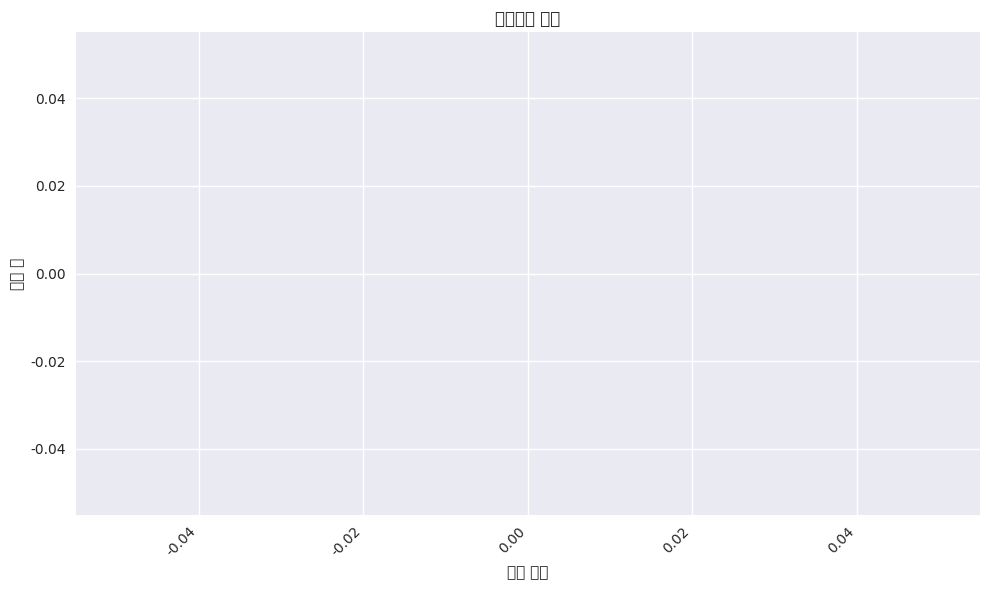

ValueError: max() iterable argument is empty

In [4]:
# 클래스 분포 시각화
classes = dataset.categories
class_names = [classes.get(i, f"Class {i}") for i in sorted(stats['class_counts'].keys())]
class_counts = [stats['class_counts'][i] for i in sorted(stats['class_counts'].keys())]

plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, class_counts)

# 색상 설정
colors = plt.cm.rainbow(np.linspace(0, 1, len(class_names)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.xlabel('알약 종류')
plt.ylabel('박스 수')
plt.title('클래스별 분포')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 불균형 비율
imbalance_ratio = max(class_counts) / min(class_counts)
print(f"\n클래스 불균형 비율: {imbalance_ratio:.2f}:1")


## 5. 박스 크기 분석

In [ ]:
if stats['box_sizes']:
    widths, heights = zip(*stats['box_sizes'])
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 너비 분포
    axes[0].hist(widths, bins=50, alpha=0.7, color='blue')
    axes[0].axvline(np.mean(widths), color='red', linestyle='--',
                    label=f'평균: {np.mean(widths):.1f}')
    axes[0].set_xlabel('너비 (pixels)')
    axes[0].set_ylabel('빈도')
    axes[0].set_title('박스 너비 분포')
    axes[0].legend()
    
    # 높이 분포
    axes[1].hist(heights, bins=50, alpha=0.7, color='green')
    axes[1].axvline(np.mean(heights), color='red', linestyle='--',
                    label=f'평균: {np.mean(heights):.1f}')
    axes[1].set_xlabel('높이 (pixels)')
    axes[1].set_ylabel('빈도')
    axes[1].set_title('박스 높이 분포')
    axes[1].legend()
    
    # 산점도
    axes[2].scatter(widths, heights, alpha=0.5, s=1)
    axes[2].set_xlabel('너비 (pixels)')
    axes[2].set_ylabel('높이 (pixels)')
    axes[2].set_title('박스 크기 분포')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n박스 크기 통계:")
    print(f"평균 크기: {np.mean(widths):.1f} x {np.mean(heights):.1f}")
    print(f"최소 크기: {min(widths):.0f} x {min(heights):.0f}")
    print(f"최대 크기: {max(widths):.0f} x {max(heights):.0f}")


## 6. 샘플 시각화

In [ ]:
# 시각화 도구
visualizer = Visualizer()

# 랜덤 샘플 선택
sample_indices = np.random.choice(len(dataset), 6, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, sample_idx in enumerate(sample_indices):
    ax = axes[idx]
    
    # 데이터 가져오기
    image, target = dataset[sample_idx]
    img_info = dataset.get_img_info(sample_idx)
    
    # numpy 배열로 변환
    if torch.is_tensor(image):
        image = image.numpy()
    
    # 이미지 표시
    ax.imshow(image)
    
    # 박스 그리기
    boxes = target['boxes'].numpy()
    labels = target['labels'].numpy()
    
    for box, label in zip(boxes, labels):
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1
        
        rect = plt.Rectangle((x1, y1), w, h,
                           linewidth=2,
                           edgecolor='red',
                           facecolor='none')
        ax.add_patch(rect)
        
        # 레이블
        class_name = dataset.categories.get(label, f"Class {label}")
        ax.text(x1, y1-5, class_name,
               bbox=dict(facecolor='red', alpha=0.5),
               fontsize=8, color='white')
    
    ax.set_title(f"Image {sample_idx}: {len(boxes)} boxes")
    ax.axis('off')

plt.tight_layout()
plt.show()

## 7. 이미지당 박스 수 분석

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(stats['boxes_per_image'], 
         bins=range(0, max(stats['boxes_per_image'])+2),
         alpha=0.7, color='purple', edgecolor='black')

plt.axvline(np.mean(stats['boxes_per_image']), color='red', linestyle='--',
            label=f'평균: {np.mean(stats['boxes_per_image']):.2f}')
plt.axvline(np.median(stats['boxes_per_image']), color='green', linestyle='--',
            label=f'중앙값: {np.median(stats['boxes_per_image']):.0f}')

plt.xlabel('이미지당 박스 수')
plt.ylabel('이미지 수')
plt.title('이미지당 박스 수 분포')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. 데이터 품질 체크

In [ ]:
# 이상치 검출
issues = {
    'no_boxes': [],
    'too_small': [],
    'too_large': [],
    'extreme_ratio': []
}

MIN_SIZE = 10
MAX_SIZE = 500

for i in range(len(dataset)):
    img, target = dataset[i]
    boxes = target['boxes'].numpy()
    
    # 박스가 없는 이미지
    if len(boxes) == 0:
        issues['no_boxes'].append(i)
    
    # 박스 크기 검사
    for box in boxes:
        w = box[2] - box[0]
        h = box[3] - box[1]
        
        if w < MIN_SIZE or h < MIN_SIZE:
            issues['too_small'].append((i, w, h))
        
        if w > MAX_SIZE or h > MAX_SIZE:
            issues['too_large'].append((i, w, h))
        
        ratio = w / h if h > 0 else 0
        if ratio < 0.2 or ratio > 5:
            issues['extreme_ratio'].append((i, ratio))

print("=== 데이터 품질 이슈 ===")
print(f"박스 없는 이미지: {len(issues['no_boxes'])}개")
print(f"너무 작은 박스: {len(issues['too_small'])}개")
print(f"너무 큰 박스: {len(issues['too_large'])}개")
print(f"극단적 종횡비: {len(issues['extreme_ratio'])}개")

## 9. 권장사항

In [ ]:
print("=== 데이터 분석 기반 권장사항 ===\n")

# 클래스 불균형
if imbalance_ratio > 2:
    print("1. 클래스 불균형 해결:")
    print(f"   - 불균형 비율: {imbalance_ratio:.1f}:1")
    print("   - 해결방안: 클래스 가중치 사용 또는 오버샘플링")

# 박스 크기
print(f"\n2. 앵커 박스 크기 설정:")
print(f"   - 추천 크기: {int(np.percentile(widths, 20))}-{int(np.percentile(widths, 80))} pixels")

# 배치 크기
avg_boxes = np.mean(stats['boxes_per_image'])
if avg_boxes > 5:
    print(f"\n3. 메모리 고려사항:")
    print(f"   - 이미지당 평균 {avg_boxes:.1f}개 박스")
    print("   - 권장 배치 크기: 4-8")

# 데이터 증강
print("\n4. 데이터 증강 전략:")
print("   - 수평 플립: 권장")
print("   - 회전: ±15도 권장")
print("   - 스케일: 0.8-1.2 권장")

## 10. 결과 저장

In [ ]:
# 분석 결과 저장
analysis_results = {
    'dataset_stats': {
        'total_images': stats['total_images'],
        'total_boxes': stats['total_boxes'],
        'avg_boxes_per_image': float(np.mean(stats['boxes_per_image'])),
        'class_distribution': dict(stats['class_counts'])
    },
    'box_stats': {
        'avg_width': float(np.mean(widths)),
        'avg_height': float(np.mean(heights)),
        'min_size': (float(min(widths)), float(min(heights))),
        'max_size': (float(max(widths)), float(max(heights)))
    },
    'quality_issues': {
        'no_boxes': len(issues['no_boxes']),
        'too_small': len(issues['too_small']),
        'too_large': len(issues['too_large'])
    }
}

# JSON으로 저장
output_path = Path('data_analysis_results.json')
with open(output_path, 'w') as f:
    json.dump(analysis_results, f, indent=2)

print(f"\n분석 결과 저장: {output_path}")